In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from nltk.stem.snowball import SnowballStemmer
import re
from nltk import word_tokenize
from nltk.corpus import stopwords
import string
from collections import defaultdict
import time
import pickle
import numpy as np
import boto3
%matplotlib inline

In [2]:
snowball = SnowballStemmer('english')
stopword_set = set(stopwords.words('english'))

In [3]:
df_reviews = pd.read_csv("s3://dogfaces/reviews/reviews.csv")

In [4]:
df_reviews.head()

,rating,review_content,review_id,review_time,toy_id,toy_name,user_name
0,5,My Fur Baby loves his Rope pull toy. I brings ...,185682550,"Sep 4, 2017",108574,mammoth-cottonblend-5-knot-dog-rope,Gunnerfavorite
1,5,We love this toy. I got the largest size for m...,185591533,"Sep 1, 2017",108574,mammoth-cottonblend-5-knot-dog-rope,Lindsay
2,4,this was a good product but not for very stron...,185522967,"Aug 29, 2017",108574,mammoth-cottonblend-5-knot-dog-rope,bcodpas3
3,5,The dogs aren't big chewers so the rope is hol...,185487336,"Aug 28, 2017",108574,mammoth-cottonblend-5-knot-dog-rope,SickPup
4,5,My Aussies love this rope. It's long enough th...,185484167,"Aug 28, 2017",108574,mammoth-cottonblend-5-knot-dog-rope,AussieMom


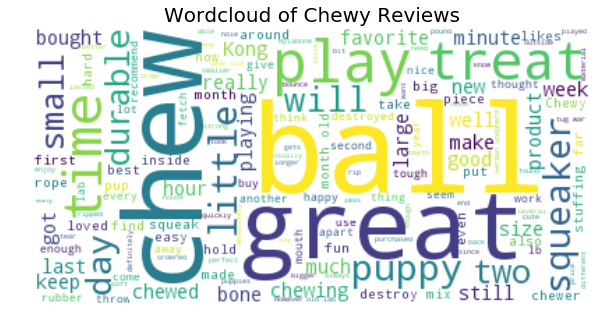

In [5]:
# show a word cloud
stopwords = set(STOPWORDS)
stopwords.add("dog")
stopwords.add("dogs")
stopwords.add("toy")
stopwords.add("love")
stopwords.add("loves")
stopwords.add("toys")
stopwords.add("one")
wc = WordCloud(background_color="white", max_words=2000, stopwords=stopwords)
cloud = wc.generate(' '.join(df_reviews['review_content'].sample(n=1000).values))
plt.figure(figsize=(10,8))
plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')
plt.title('Wordcloud of Chewy Reviews', fontsize=20)
plt.show()

### Read dog breed information

In [6]:
# source1: web 
df_breed = pd.read_csv("breed_nick_names.txt",names=['breed_info'])
df_breed.head()

,breed_info
0,1. Labrador Retriever = Lab
1,2. Yorkshire Terrier = Yorkie
2,3. German Shepherd Dog = GShep or GSD
3,4. Golden Retrievers = Golden
4,5. Beagles = Beagle


In [7]:
df_breed.shape

(160, 1)

In [8]:
breeds_info = df_breed['breed_info'].values
breed_dict = {}
for breed in breeds_info:
    temp = breed.lower()
    temp = re.findall('\d.\s+(\D*)', temp)[0]
    temp = temp.strip().split('=')
    breed_dict[temp[0].strip()] = temp[1].strip()

In [9]:
# 1. different nicek names are separated with 'or'
for k, v in breed_dict.iteritems():
    breed_dict[k] = map(lambda x:x.strip(), v.split(' or '))

In [10]:
# 2. get n-gram and stemmed words breed_dict
for k, v in breed_dict.iteritems():
    breed_dict[k] = set(v)
    breed_dict[k].add(k)
    temp_set = set([snowball.stem(x) for x in breed_dict[k]])
    breed_dict[k] = breed_dict[k]|temp_set
    for word in word_tokenize(k):
        breed_dict[k].add(word)
        breed_dict[k].add(snowball.stem(word))
    breed_dict[k] = breed_dict[k] - {'dog', 'dogs'} - stopword_set

In [11]:
print breed_dict['chow chows']

set([u'chow', u'chow chow', 'chow chows', 'chows'])


In [12]:
breed_lookup = defaultdict(set)
for k, v in breed_dict.iteritems():
    for word in v:
        breed_lookup[word].add(k)
breed_lookup.keys()
del_list = ['toy','blue','great','duck','coat','wire','st.','white','grey',
            'black','old','smooth','west','soft']
for w in del_list:
    breed_lookup.pop(w, None)
print len(breed_lookup)

604


In [13]:
# polish the look up tables based on 52 base classes
breed_classes = pd.read_csv("s3://dogfaces/tensor_model/output_labels_20170907.txt",names=['breed'])
base_breeds = breed_classes['breed'].values
not_found_breed = []
for breed in base_breeds:
    if breed not in breed_dict:
        if breed in breed_lookup:
            if len(breed_lookup[breed])==1:
                breed_in_dict = list(breed_lookup[breed])[0]
                breed_dict[breed] = breed_dict[breed_in_dict]
                breed_dict[breed].add(breed_in_dict)
                breed_dict.pop(breed_in_dict, None)
                print "replace the key {} with {}".format(breed_in_dict, breed)
            else:
                print breed, breed_lookup[breed]
        elif snowball.stem(breed) in breed_lookup:
            breed_stem = snowball.stem(breed)
            if len(breed_lookup[breed_stem])==1:
                breed_in_dict = list(breed_lookup[breed_stem])[0]
                breed_dict[breed] = breed_dict[breed_in_dict]
                breed_dict[breed].add(breed_in_dict)
                breed_dict.pop(breed_in_dict, None)
            else:
                print breed,breed_stem, breed_lookup[breed_stem]
        else:
            not_found_breed.append(breed)
print "not found these breeds:"
print not_found_breed

replace the key french bulldogs with french bulldog
replace the key cairn terriers with cairn
replace the key belgian malinois with malinois
replace the key collies with collie
replace the key samoyeds with samoyed
replace the key doberman pinscher with doberman
replace the key shetland sheepdogs with shetland sheepdog
replace the key whippets with whippet
replace the key beagles with beagle
replace the key english foxhounds with english foxhound
basset set(['basset hound', 'petits bassets griffons vendeens'])
replace the key bernese mountain dogs with bernese mountain dog
replace the key tibetan mastiffs with tibetan mastiff
replace the key chow chows with chow
replace the key boxers with boxer
replace the key rhodesian ridgebacks with rhodesian ridgeback
not found these breeds:
['bull mastiff', 'standard poodle', 'wheaten terrier', 'american bulldog', 'english springer', 'miniature poodle', 'toy poodle', 'german shorthaired', 'german shepherd']


* for poodles:create each type of poodle a separate look up item and delete the original poodle one. 
* to add: american bulldog, merge with bulldog here  
* to add: bull mastiff = bullmstiffs
* to add english springer = 'english springer spaniels'  
* german shorhaired = 'german shorthaired pointers'
* german shepherd = 'german shepherd dog'
* to add basset and merge ['basset hound', 'petits bassets griffons vendeens']

In [14]:
# poodles:
for breed in not_found_breed:
    if breed.endswith('poodle') or breed=='wheaten terrier':
        breed_dict[breed] = set(breed.split())|set([snowball.stem(w) for w in breed.split()])
    breed_dict.pop('poodle', None)

In [15]:
# bullmastiff
if 'bull mastiff' in not_found_breed:
    breed_dict['bull mastiff'] = breed_dict['bullmastiffs']
    breed_dict.pop('bullmastiffs', None)

In [16]:
# english springer
if 'english springer' in not_found_breed:
    breed_dict['english springer'] = breed_dict['english springer spaniels']
    breed_dict.pop('english springer spaniels', None)

In [17]:
# german short haired, german shepherd and 'american bulldog'
name = 'american bulldog'
if name in not_found_breed:
    breed_dict[name]  = breed_dict['bulldog'] | set(name.split()) | set([snowball.stem(w) for w in name.split()])
    breed_dict.pop('bulldog', None)

name = 'german shorthaired'
if name in not_found_breed:
    breed_dict[name] = breed_dict['german shorthaired pointers']
    breed_dict.pop('german shorthaired pointers', None)
name = 'german shepherd'
if name in not_found_breed:
    breed_dict[name] = breed_dict['german shepherd dog']
    breed_dict.pop('german shepherd dog', None)

In [18]:
# basset dog
breed_dict['basset'] = breed_dict['basset hound']|breed_dict['petits bassets griffons vendeens']

In [19]:
'basset' in base_breeds

True

In [59]:
sorted(breed_dict.keys())

['affenpinschers',
 'afghan hounds',
 'airedale terriers',
 'akita',
 'american bulldog',
 'american eskimo dogs',
 'american pit bull terrier',
 'american staffordshire terriers',
 'american sussex foxhounds',
 'american water spaniels',
 'anatolian shepherd dogs',
 'australian cattle dogs',
 'australian shepherd',
 'australian terriers',
 'basenjis',
 'basset hound',
 'beagle',
 'bearded collies',
 'beauceron',
 'bedlington terriers',
 'belgian sheepdogs',
 'belgian tervuren',
 'bernese mountain dog',
 'bichons frises',
 'black and tan coonhounds',
 'black russian terriers',
 'bloodhound',
 'border collie',
 'border terriers',
 'borzois',
 'boston terrier',
 'bouviers flandres',
 'boxer',
 'briards',
 'brittany spaniel',
 'brussels griffons',
 'bull mastiff',
 'bull terriers',
 'cairn',
 'canaan dogs',
 'cardigan welsh corgis',
 'cavalier king charles spaniels',
 'chesapeake bay retriever',
 'chihuahua',
 'chinese crested',
 'chinese shar-pei',
 'chow',
 'clumber spaniels',
 'cocker 

In [31]:
ind = np.random.randint(df_reviews.shape[0])
text_review = df_reviews['review_content'][ind].lower()
print text_review
puncs = string.punctuation
reduced_set = set([snowball.stem(x) for x in (set(filter(lambda x: x not in puncs, word_tokenize(text_review))) 
 - stopword_set)])
po_breeds = []
for w in reduced_set:
    if w in breed_lookup:
        po_breeds.extend(breed_lookup[w])
print po_breeds

we really like this ball! it's a nice small size, has a nice bounce, tough against chewing and it still squeaks! nice and easy for my little dogs to catch in their mouths.
[]


In [68]:
df_reviews.columns

Index([u'rating', u'review_content', u'review_id', u'review_time', u'toy_id',
       u'toy_name', u'user_name'],
      dtype='object')

In [32]:
def getReviewBreed(text):
    ntext = text.decode('utf-8')
    reduced_set = set([snowball.stem(x) for x in 
                       (set(filter(lambda x: x not in string.punctuation, 
                                   word_tokenize(ntext.lower()))) - stopword_set)])
    po_breeds = []
    for w in reduced_set:
        if w in breed_lookup:
            po_breeds.extend(breed_lookup[w])
    return po_breeds

def getBreedTable(df):
    N = df.shape[0]
    breed = []
    review_id = []
    toy_id = []
    for ind, row in df.iterrows():
        breed.append(getReviewBreed(row['review_content']))
        review_id.append(row['review_id'])
        toy_id.append(row['toy_id'])
    return pd.DataFrame({'review_id':review_id, 'toy_id':toy_id, 'breed_extract':breed})

In [33]:
test_df = df_reviews.copy()
start_time = time.time()
new_df = getBreedTable(test_df)
print time.time() - start_time

85.166260004


In [34]:
new_df.head()

,breed_extract,review_id,toy_id
0,[],185682550,108574
1,[weimaraner],185591533,108574
2,"[border collies, border terriers]",185522967,108574
3,[],185487336,108574
4,"[australian cattle dogs, australian shepherd]",185484167,108574


In [35]:
df_reviews['review_content'][1]

"We love this toy. I got the largest size for my weim and so far it's lasted 3 weeks. I put it away when I'm not engaging with him because he can pull out the small threads on the ends. But all in all, a high quality rope toy."

In [36]:
new_df.shape

(61202, 3)

In [37]:
df_extract = pd.merge(df_reviews, new_df, on=['review_id', 'toy_id'])
df_extract.pop('review_content')
print df_extract.shape
df_extract.head()

(61202, 7)


,rating,review_id,review_time,toy_id,toy_name,user_name,breed_extract
0,5,185682550,"Sep 4, 2017",108574,mammoth-cottonblend-5-knot-dog-rope,Gunnerfavorite,[]
1,5,185591533,"Sep 1, 2017",108574,mammoth-cottonblend-5-knot-dog-rope,Lindsay,[weimaraner]
2,4,185522967,"Aug 29, 2017",108574,mammoth-cottonblend-5-knot-dog-rope,bcodpas3,"[border collies, border terriers]"
3,5,185487336,"Aug 28, 2017",108574,mammoth-cottonblend-5-knot-dog-rope,SickPup,[]
4,5,185484167,"Aug 28, 2017",108574,mammoth-cottonblend-5-knot-dog-rope,AussieMom,"[australian cattle dogs, australian shepherd]"


In [65]:
#ind = np.random.randint(df_extract.shape[0])
ind = 4
print df_reviews['review_content'][ind]
print df_extract['breed_extract'][ind]

My Aussies love this rope. It's long enough that they can get a good tug of war going. Very well made and holding together so far.
['australian cattle dogs', 'australian shepherd']


In [83]:
df_extract['breed_extract'] = df_extract['breed_extract'].apply(lambda row:','.join(row))

In [84]:
df_extract.head()

,rating,review_id,review_time,toy_id,toy_name,user_name,breed_extract
0,5,185682550,"Sep 4, 2017",108574,mammoth-cottonblend-5-knot-dog-rope,Gunnerfavorite,
1,5,185591533,"Sep 1, 2017",108574,mammoth-cottonblend-5-knot-dog-rope,Lindsay,weimaraner
2,4,185522967,"Aug 29, 2017",108574,mammoth-cottonblend-5-knot-dog-rope,bcodpas3,"border terriers,border collie"
3,5,185487336,"Aug 28, 2017",108574,mammoth-cottonblend-5-knot-dog-rope,SickPup,
4,5,185484167,"Aug 28, 2017",108574,mammoth-cottonblend-5-knot-dog-rope,AussieMom,"australian cattle dogs,australian shepherd"


In [85]:
np.sum(df_extract['breed_extract'].isnull())

0

In [78]:
breed_lookup['poodle']

{'miniature poodle', 'standard poodle', 'toy poodle'}

#### Save intermediate import dictionaries and results

In [86]:
save_data = df_extract.to_csv(index=False)
s3_res = boto3.resource('s3')
s3_res.Bucket('dogfaces').put_object(Key='reviews/extract_breed_review.csv', Body=save_data)

s3.Object(bucket_name='dogfaces', key='reviews/extract_breed_review.csv')

In [66]:
# save breed_lookup
# save breed_dict
with open('breed_lookup.pickle', 'wb') as handle:
    pickle.dump(breed_lookup, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('breed_dict.pickle', 'wb') as handle:
    pickle.dump(breed_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [7]:
# source 2: classified dog names
breed_classes = pd.read_csv("s3://dogfaces/tensor_model/output_labels_20170907.txt",names=['breed'])
breed_classes.head()

,breed
0,rottweiler
1,bull mastiff
2,french bulldog
3,cairn
4,yorkshire terrier


#### Get breed scores

In [81]:
# generate a data frame, review_id, toy_id, breed
len(df_extract['review_id'].unique())

61202